In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import tensorflow as tf
import tensorflow_hub as hub
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.optimizers import legacy

try:
    from keras.optimizer import Adam
except:
    from tensorflow.keras.optimizers import Adam
    
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=0)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0, 
                              patience=3, 
                              verbose=1,
                              restore_best_weights=True)

In [3]:
MAIN_DIR = "/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset"
train_dir = MAIN_DIR + "/Train"
test_dir = MAIN_DIR + "/Test"

In [4]:
for dirpath, dirnames, filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

3 directories and 1 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset'
2 directories and 2 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Test'
0 directories and 93 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Test/Defective'
0 directories and 101 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Test/Not Defective'
2 directories and 2 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Train'
0 directories and 401 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Train/Non-Defective'
0 directories and 370 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/Train/Defective'
0 directories and 0 images in '/Users/paulinakoprowska/Downloads/Pepsico RnD Potato Lab Dataset/.ipynb_checkpoints'


In [15]:
img_size , batch_size, num_seed = (224,224), 32, 27

test_gen = ImageDataGenerator(rescale=1./255)

def color_augmentation(image):
    
    contrast_factor = np.random.uniform(0.5, 1.0)
    image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=0)

    blur_size = np.random.choice([3, 5, 7])
    image = cv2.GaussianBlur(image, (blur_size, blur_size), 0)

    return image.astype(np.float32)

train_data_augment_gen = ImageDataGenerator(rescale=1/255.,
                              width_shift_range=0.3,
                              height_shift_range=0.3,
                              rotation_range=0.2,
                              shear_range=0.2,
                              vertical_flip=True,
                              brightness_range=(0.9, 1.2),
                              zoom_range=0.2,
                              horizontal_flip=True,
                              validation_split=0.2,
                              preprocessing_function=color_augmentation)

train_argument = {'batch_size':batch_size,
              'target_size':img_size,
              'class_mode':"binary",
              'shuffle':True,
              'seed':num_seed}

test_arg = {'batch_size':batch_size,
             'target_size':img_size,
             'class_mode':"binary",
             'shuffle':False,
             'seed':num_seed}

train_data = train_data_augment_gen.flow_from_directory(
    directory=train_dir, subset='training', **train_argument)
valid_data = train_data_augment_gen.flow_from_directory(
    directory=train_dir, subset='validation', **train_argument)
test_data = test_gen.flow_from_directory(
    directory=test_dir, **test_arg)

Found 616 images belonging to 2 classes.
Found 153 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


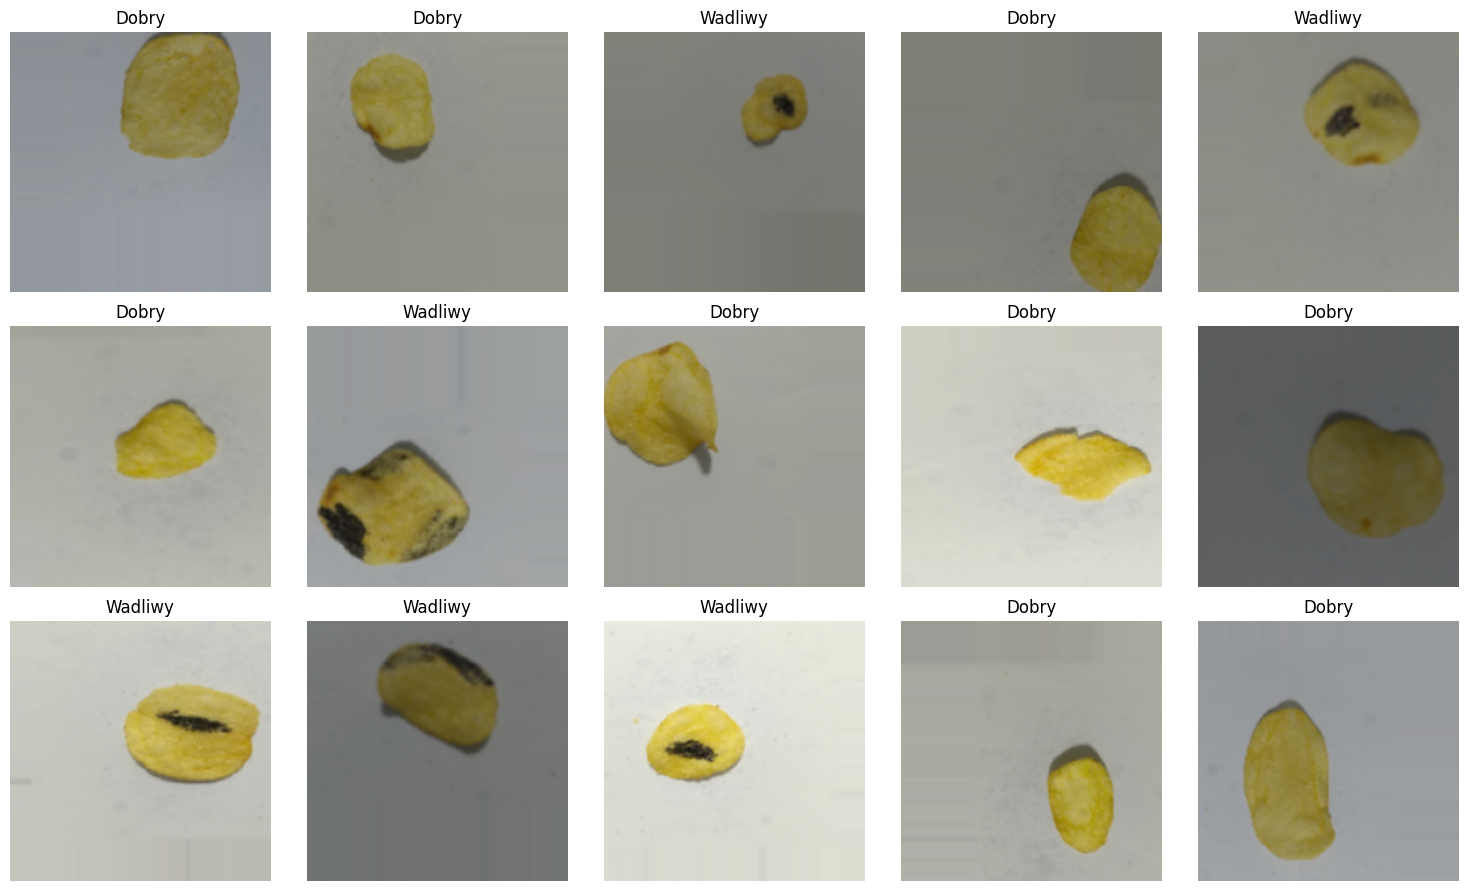

In [7]:
plt.figure(figsize=(15,9))

for i in range(15):
    axs = plt.subplot(3,5,i+1)
    x, y = train_data.next()
    plt.imshow(x[i])
    plt.axis('off')
    axs.set_title("Wadliwy" if y[i] == 0 else "Dobry")
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [8]:
model_cnn_upgrade = Sequential([
    Input(shape=(224,224, 3), name="input_layer"),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn_upgrade.compile(loss=BinaryCrossentropy(),
             optimizer=legacy.Adam(),
             metrics=['accuracy'])

model_cnn_upgrade.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 16)        0

In [9]:
training_history_upgrade = model_cnn_upgrade.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/5
20/20 [==============================] - 51s 3s/step - loss: 0.7095 - accuracy: 0.4968 - val_loss: 0.6927 - val_accuracy: 0.5686
Epoch 2/5
20/20 [==============================] - 48s 2s/step - loss: 0.6921 - accuracy: 0.5942 - val_loss: 0.6901 - val_accuracy: 0.6405
Epoch 3/5
20/20 [==============================] - 47s 2s/step - loss: 0.6890 - accuracy: 0.5698 - val_loss: 0.6804 - val_accuracy: 0.7712
Epoch 4/5
20/20 [==============================] - 47s 2s/step - loss: 0.6738 - accuracy: 0.7825 - val_loss: 0.6478 - val_accuracy: 0.6340
Epoch 5/5
20/20 [==============================] - 50s 3s/step - loss: 0.6072 - accuracy: 0.8117 - val_loss: 0.5660 - val_accuracy: 0.7712


In [11]:
def plot_curves(history):

    """
    Returns separate loss and accuracy curves
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="straty trenowania")
    plt.plot(epochs, val_loss, label="straty walidacji")
    plt.title("strata")
    plt.xlabel("epoki")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="dokładność trenowania")
    plt.plot(epochs, val_accuracy, label="dokładność walidacji")
    plt.title("dokładność")
    plt.xlabel("epoki")
    plt.legend()

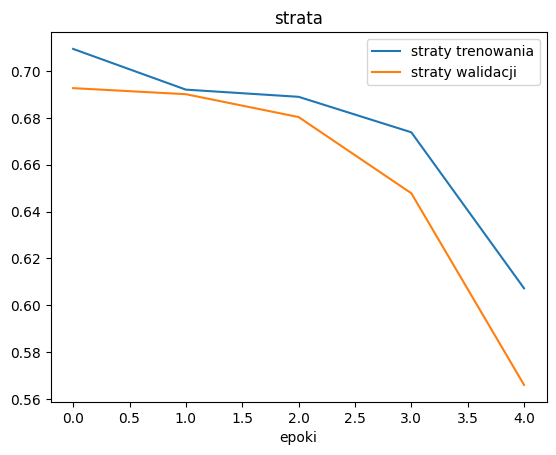

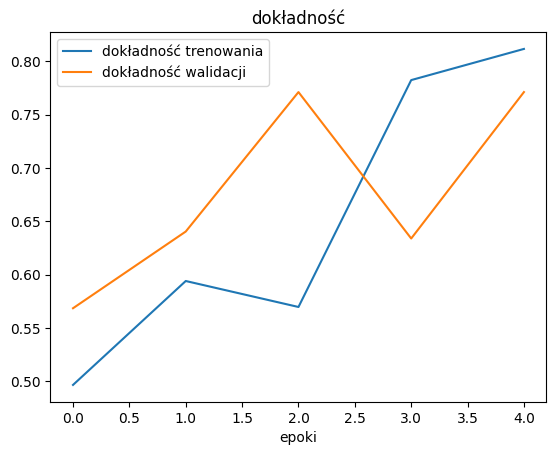

In [12]:
plot_curves(training_history_upgrade)

In [16]:
result_2 = model_cnn_upgrade.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result_2[1]*100:.2f}%\nLoss: {result_2[0]:.4f}")

Accuracy on Evaluation: 81.25%
Loss: 0.4764


In [17]:
y_true_2 = test_data.labels
y_pred_2 = model_cnn_upgrade.predict(test_data, verbose=0)
y_pred_2[y_pred_2 < 0.5] = 0
y_pred_2[y_pred_2 >= 0.5] = 1

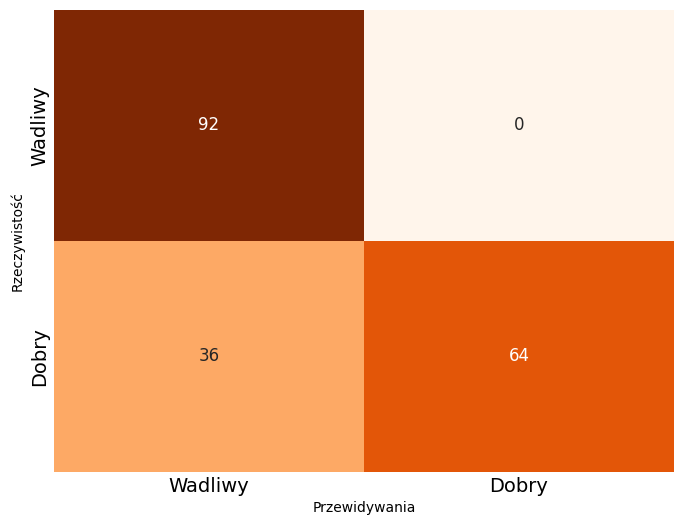

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax=sns.heatmap(confusion_matrix(y_true_2,y_pred_2), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Oranges')
ax.set_xticklabels(['Wadliwy', 'Dobry'])
ax.set_yticklabels(['Wadliwy', 'Dobry'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.xlabel('Przewidywania')
plt.ylabel('Rzeczywistość')
plt.show()

In [19]:
print(classification_report(y_true_2, y_pred_2, digits=4))

              precision    recall  f1-score   support

           0     0.7188    1.0000    0.8364        92
           1     1.0000    0.6400    0.7805       100

    accuracy                         0.8125       192
   macro avg     0.8594    0.8200    0.8084       192
weighted avg     0.8652    0.8125    0.8073       192



In [20]:
model_cnn_upgrade_2 = Sequential([
    Input(shape=(224,224, 3), name="input_layer"),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn_upgrade_2.compile(loss=BinaryCrossentropy(),
             optimizer=legacy.Adam(),
             metrics=['accuracy'])

model_cnn_upgrade_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 16)       

In [21]:
training_history_upgrade_2 = model_cnn_upgrade_2.fit(train_data,
            epochs=10,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/10
20/20 [==============================] - 52s 3s/step - loss: 0.7833 - accuracy: 0.4870 - val_loss: 0.6923 - val_accuracy: 0.4902
Epoch 2/10
20/20 [==============================] - 49s 2s/step - loss: 0.6941 - accuracy: 0.5455 - val_loss: 0.6909 - val_accuracy: 0.4771
Epoch 3/10
20/20 [==============================] - 50s 2s/step - loss: 0.6921 - accuracy: 0.6169 - val_loss: 0.6873 - val_accuracy: 0.4837
Epoch 4/10
20/20 [==============================] - 49s 2s/step - loss: 0.6757 - accuracy: 0.7532 - val_loss: 0.6433 - val_accuracy: 0.5621
Epoch 5/10
20/20 [==============================] - 50s 2s/step - loss: 0.5825 - accuracy: 0.8295 - val_loss: 0.5295 - val_accuracy: 0.9542
Epoch 6/10
20/20 [==============================] - 49s 2s/step - loss: 0.4635 - accuracy: 0.9075 - val_loss: 0.3935 - val_accuracy: 0.9281
Epoch 7/10
20/20 [==============================] - 47s 2s/step - loss: 0.4023 - accuracy: 0.9156 - val_loss: 0.3621 - val_accuracy: 0.9477
Epoch 8/10
20/20 [==

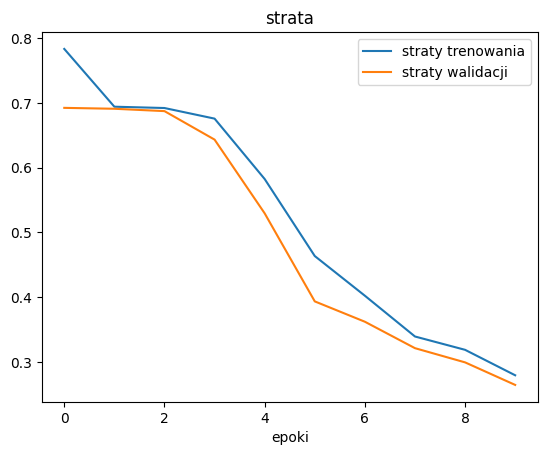

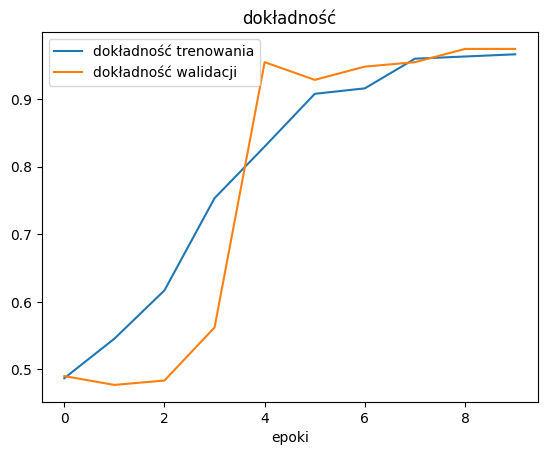

In [22]:
plot_curves(training_history_upgrade_2)

In [23]:
result_3 = model_cnn_upgrade_2.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result_3[1]*100:.2f}%\nLoss: {result_3[0]:.4f}")

Accuracy on Evaluation: 98.96%
Loss: 0.2312


In [24]:
y_true_3 = test_data.labels
y_pred_3 = model_cnn_upgrade_2.predict(test_data, verbose=0)
y_pred_3[y_pred_3 < 0.5] = 0
y_pred_3[y_pred_3 >= 0.5] = 1

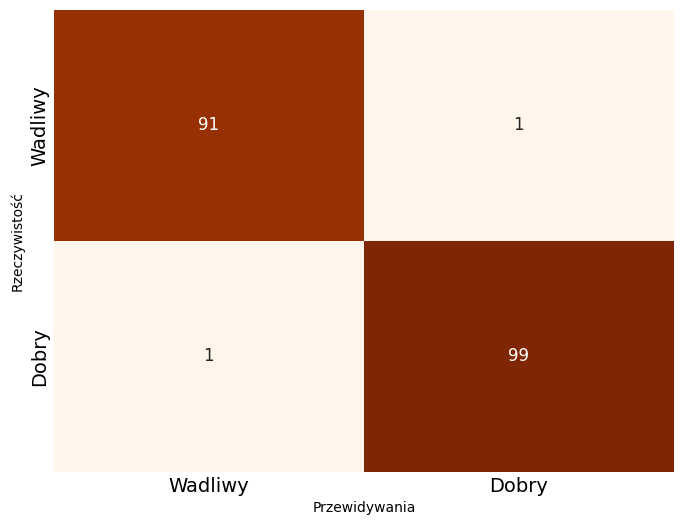

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax=sns.heatmap(confusion_matrix(y_true_3,y_pred_3), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Oranges')
ax.set_xticklabels(['Wadliwy', 'Dobry'])
ax.set_yticklabels(['Wadliwy', 'Dobry'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.xlabel('Przewidywania')
plt.ylabel('Rzeczywistość')
plt.show()

In [26]:
print(classification_report(y_true_3, y_pred_3, digits=4))

              precision    recall  f1-score   support

           0     0.9891    0.9891    0.9891        92
           1     0.9900    0.9900    0.9900       100

    accuracy                         0.9896       192
   macro avg     0.9896    0.9896    0.9896       192
weighted avg     0.9896    0.9896    0.9896       192



In [27]:
model_cnn_upgrade_3 = Sequential([
    Input(shape=(224,224, 3), name="input_layer"),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn_upgrade_3.compile(loss=BinaryCrossentropy(),
             optimizer=legacy.Adam(),
             metrics=['accuracy'])

model_cnn_upgrade_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 16)       

In [28]:
training_history_upgrade_3 = model_cnn_upgrade_3.fit(train_data,
            epochs=15,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/15
20/20 [==============================] - 49s 2s/step - loss: 0.7126 - accuracy: 0.5081 - val_loss: 0.6925 - val_accuracy: 0.5229
Epoch 2/15
20/20 [==============================] - 47s 2s/step - loss: 0.6940 - accuracy: 0.5081 - val_loss: 0.6913 - val_accuracy: 0.5948
Epoch 3/15
20/20 [==============================] - 47s 2s/step - loss: 0.7043 - accuracy: 0.6120 - val_loss: 0.6922 - val_accuracy: 0.5294
Epoch 4/15
20/20 [==============================] - 49s 3s/step - loss: 0.6915 - accuracy: 0.5487 - val_loss: 0.6881 - val_accuracy: 0.6340
Epoch 5/15
20/20 [==============================] - 48s 2s/step - loss: 0.6765 - accuracy: 0.7435 - val_loss: 0.6381 - val_accuracy: 0.7582
Epoch 6/15
20/20 [==============================] - 47s 2s/step - loss: 0.6259 - accuracy: 0.7711 - val_loss: 0.5339 - val_accuracy: 0.8693
Epoch 7/15
20/20 [==============================] - 47s 2s/step - loss: 0.4794 - accuracy: 0.9026 - val_loss: 0.3935 - val_accuracy: 0.9673
Epoch 8/15
20/20 [==

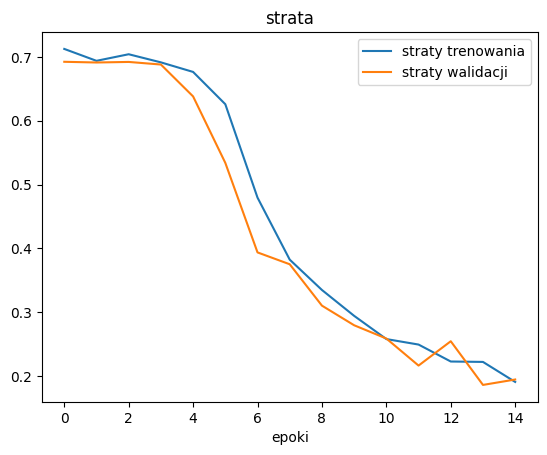

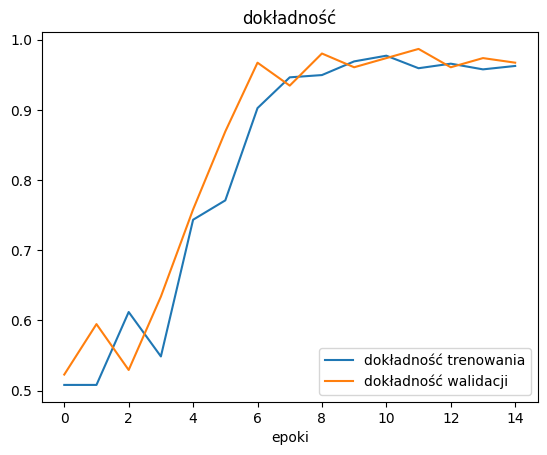

In [29]:
plot_curves(training_history_upgrade_3)

In [30]:
result_4 = model_cnn_upgrade_3.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result_4[1]*100:.2f}%\nLoss: {result_4[0]:.4f}")

Accuracy on Evaluation: 98.96%
Loss: 0.1568


In [31]:
y_true_4 = test_data.labels
y_pred_4 = model_cnn_upgrade_3.predict(test_data, verbose=0)
y_pred_4[y_pred_4 < 0.5] = 0
y_pred_4[y_pred_4 >= 0.5] = 1

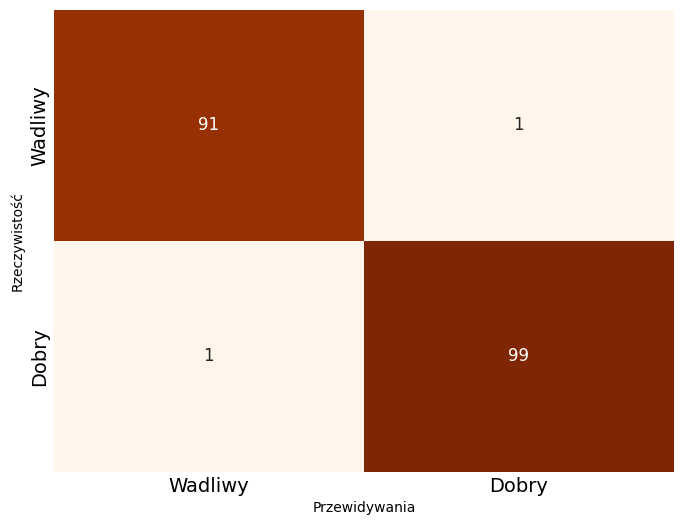

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
ax=sns.heatmap(confusion_matrix(y_true_4,y_pred_4), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Oranges')
ax.set_xticklabels(['Wadliwy', 'Dobry'])
ax.set_yticklabels(['Wadliwy', 'Dobry'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.xlabel('Przewidywania')
plt.ylabel('Rzeczywistość')
plt.show()

In [33]:
print(classification_report(y_true_4, y_pred_4, digits=4))

              precision    recall  f1-score   support

           0     0.9891    0.9891    0.9891        92
           1     0.9900    0.9900    0.9900       100

    accuracy                         0.9896       192
   macro avg     0.9896    0.9896    0.9896       192
weighted avg     0.9896    0.9896    0.9896       192



In [34]:
model_cnn_upgrade_4 = Sequential([
    Input(shape=(224,224, 3), name="input_layer"),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn_upgrade_4.compile(loss=BinaryCrossentropy(),
             optimizer=legacy.Adam(),
             metrics=['accuracy'])

model_cnn_upgrade_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 26, 26, 16)       

In [35]:
training_history_upgrade_4 = model_cnn_upgrade_4.fit(train_data,
            epochs=12,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/12
20/20 [==============================] - 49s 2s/step - loss: 0.7364 - accuracy: 0.4935 - val_loss: 0.6931 - val_accuracy: 0.5229
Epoch 2/12
20/20 [==============================] - 51s 3s/step - loss: 0.7019 - accuracy: 0.5227 - val_loss: 0.6907 - val_accuracy: 0.4902
Epoch 3/12
20/20 [==============================] - 49s 2s/step - loss: 0.6921 - accuracy: 0.5195 - val_loss: 0.6932 - val_accuracy: 0.5098
Epoch 4/12
20/20 [==============================] - 49s 2s/step - loss: 0.6927 - accuracy: 0.5308 - val_loss: 0.6915 - val_accuracy: 0.5556
Epoch 5/12
20/20 [==============================] - 48s 2s/step - loss: 0.6906 - accuracy: 0.5097 - val_loss: 0.6887 - val_accuracy: 0.4967
Epoch 6/12
20/20 [==============================] - 47s 2s/step - loss: 0.6852 - accuracy: 0.5276 - val_loss: 0.6903 - val_accuracy: 0.5294
Epoch 7/12
20/20 [==============================] - 47s 2s/step - loss: 0.6918 - accuracy: 0.5714 - val_loss: 0.6911 - val_accuracy: 0.5294
Epoch 8/12
20/20 [==

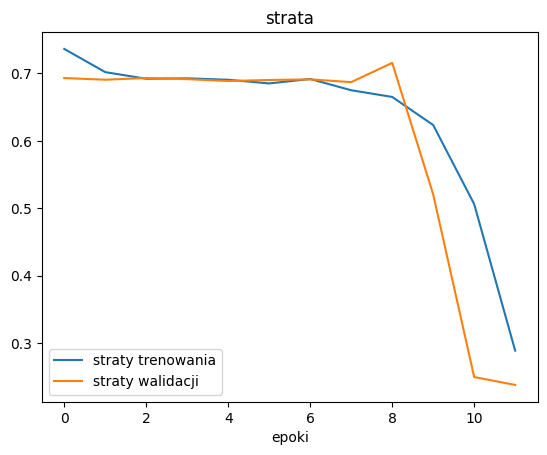

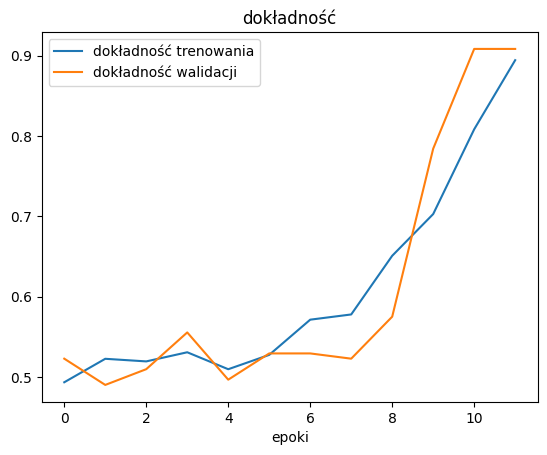

In [36]:
plot_curves(training_history_upgrade_4)

In [37]:
result_5 = model_cnn_upgrade_4.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result_5[1]*100:.2f}%\nLoss: {result_5[0]:.4f}")

Accuracy on Evaluation: 92.71%
Loss: 0.2069


In [38]:
y_true_5 = test_data.labels
y_pred_5 = model_cnn_upgrade_4.predict(test_data, verbose=0)
y_pred_5[y_pred_5 < 0.5] = 0
y_pred_5[y_pred_5 >= 0.5] = 1

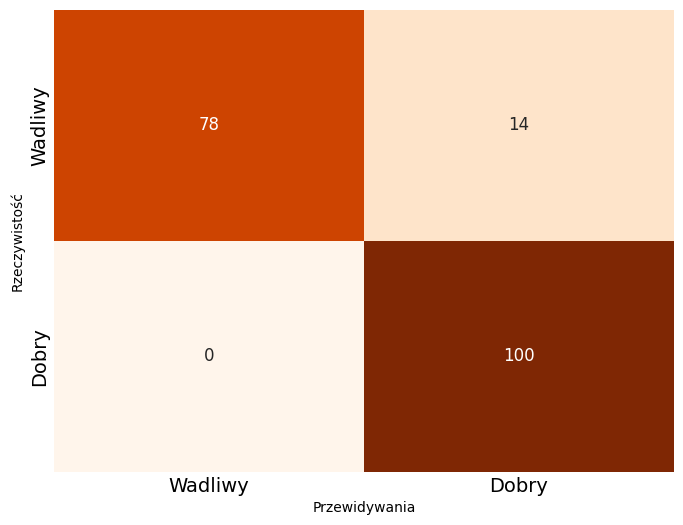

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
ax=sns.heatmap(confusion_matrix(y_true_5,y_pred_5), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Oranges')
ax.set_xticklabels(['Wadliwy', 'Dobry'])
ax.set_yticklabels(['Wadliwy', 'Dobry'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.xlabel('Przewidywania')
plt.ylabel('Rzeczywistość')
plt.show()

In [40]:
print(classification_report(y_true_5, y_pred_5, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.8478    0.9176        92
           1     0.8772    1.0000    0.9346       100

    accuracy                         0.9271       192
   macro avg     0.9386    0.9239    0.9261       192
weighted avg     0.9360    0.9271    0.9265       192



In [41]:
model_cnn_upgrade_5 = Sequential([
    Input(shape=(224,224, 3), name="input_layer"),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn_upgrade_5.compile(loss=BinaryCrossentropy(),
             optimizer=legacy.Adam(),
             metrics=['accuracy'])

model_cnn_upgrade_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 26, 26, 16)       

In [42]:
training_history_upgrade_5 = model_cnn_upgrade_5.fit(train_data,
            epochs=20,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/20
20/20 [==============================] - 49s 2s/step - loss: 0.7112 - accuracy: 0.4756 - val_loss: 0.6928 - val_accuracy: 0.5229
Epoch 2/20
20/20 [==============================] - 47s 2s/step - loss: 0.6934 - accuracy: 0.5195 - val_loss: 0.6923 - val_accuracy: 0.5229
Epoch 3/20
20/20 [==============================] - 47s 2s/step - loss: 0.6927 - accuracy: 0.5130 - val_loss: 0.6909 - val_accuracy: 0.5294
Epoch 4/20
20/20 [==============================] - 47s 2s/step - loss: 0.6966 - accuracy: 0.4821 - val_loss: 0.6903 - val_accuracy: 0.5229
Epoch 5/20
20/20 [==============================] - 47s 2s/step - loss: 0.6938 - accuracy: 0.5487 - val_loss: 0.6876 - val_accuracy: 0.7059
Epoch 6/20
20/20 [==============================] - 47s 2s/step - loss: 0.6621 - accuracy: 0.7711 - val_loss: 0.6290 - val_accuracy: 0.8627
Epoch 7/20
20/20 [==============================] - 47s 2s/step - loss: 0.5313 - accuracy: 0.8523 - val_loss: 0.4600 - val_accuracy: 0.9346
Epoch 8/20
20/20 [==

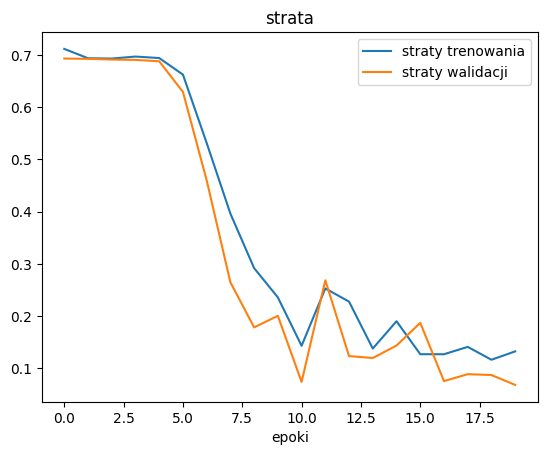

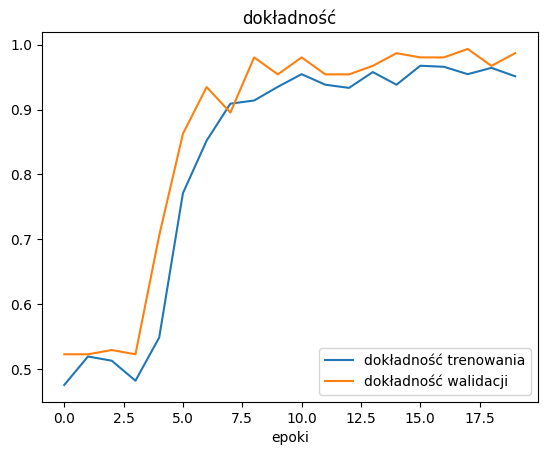

In [48]:
plot_curves(training_history_upgrade_5)

In [49]:
result_6 = model_cnn_upgrade_5.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result_6[1]*100:.2f}%\nLoss: {result_6[0]:.4f}")

Accuracy on Evaluation: 99.48%
Loss: 0.0529


In [59]:
y_true_6 = test_data.labels
y_pred_6 = model_cnn_upgrade_5.predict(test_data, verbose=0)
y_pred_6[y_pred_6 <= 0.5] = 0
y_pred_6[y_pred_6 > 0.5] = 1

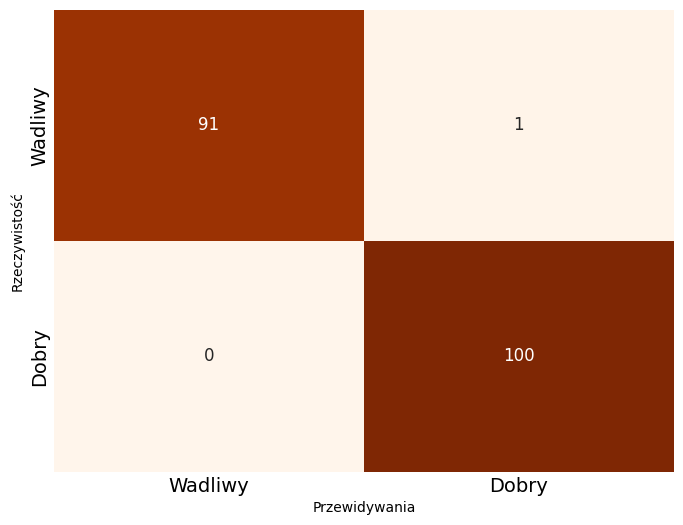

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
ax=sns.heatmap(confusion_matrix(y_true_6,y_pred_6), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Oranges')
ax.set_xticklabels(['Wadliwy', 'Dobry'])
ax.set_yticklabels(['Wadliwy', 'Dobry'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.xlabel('Przewidywania')
plt.ylabel('Rzeczywistość')
plt.show()

In [61]:
print(classification_report(y_true_6, y_pred_6, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9891    0.9945        92
           1     0.9901    1.0000    0.9950       100

    accuracy                         0.9948       192
   macro avg     0.9950    0.9946    0.9948       192
weighted avg     0.9948    0.9948    0.9948       192



In [62]:
model_cnn_upgrade_6 = Sequential([
    Input(shape=(224,224, 3), name="input_layer"),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn_upgrade_6.compile(loss=BinaryCrossentropy(),
             optimizer=legacy.Adam(),
             metrics=['accuracy'])

model_cnn_upgrade_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 26, 26, 16)       

In [63]:
training_history_upgrade_6 = model_cnn_upgrade_6.fit(train_data,
            epochs=25,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/25
20/20 [==============================] - 50s 3s/step - loss: 0.7060 - accuracy: 0.5081 - val_loss: 0.6966 - val_accuracy: 0.4771
Epoch 2/25
20/20 [==============================] - 47s 2s/step - loss: 0.6925 - accuracy: 0.5065 - val_loss: 0.6856 - val_accuracy: 0.8039
Epoch 3/25
20/20 [==============================] - 48s 2s/step - loss: 0.6876 - accuracy: 0.5455 - val_loss: 0.6818 - val_accuracy: 0.5294
Epoch 4/25
20/20 [==============================] - 47s 2s/step - loss: 0.6840 - accuracy: 0.6558 - val_loss: 0.6314 - val_accuracy: 0.6405
Epoch 5/25
20/20 [==============================] - 48s 2s/step - loss: 0.6762 - accuracy: 0.7273 - val_loss: 0.6971 - val_accuracy: 0.4771
Epoch 6/25
20/20 [==============================] - 48s 2s/step - loss: 0.6208 - accuracy: 0.7386 - val_loss: 0.5347 - val_accuracy: 0.7059
Epoch 7/25
20/20 [==============================] - 47s 2s/step - loss: 0.4538 - accuracy: 0.8896 - val_loss: 0.3984 - val_accuracy: 0.9542
Epoch 8/25
20/20 [==

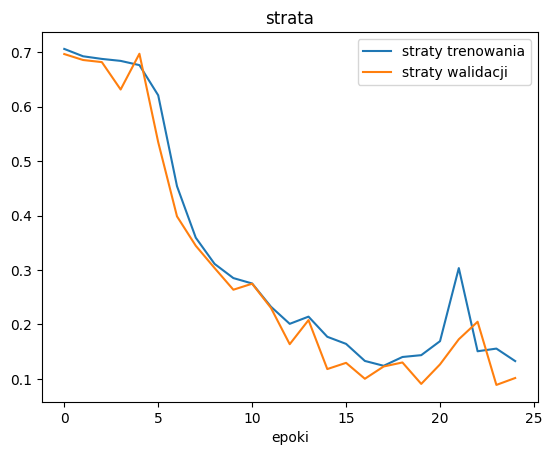

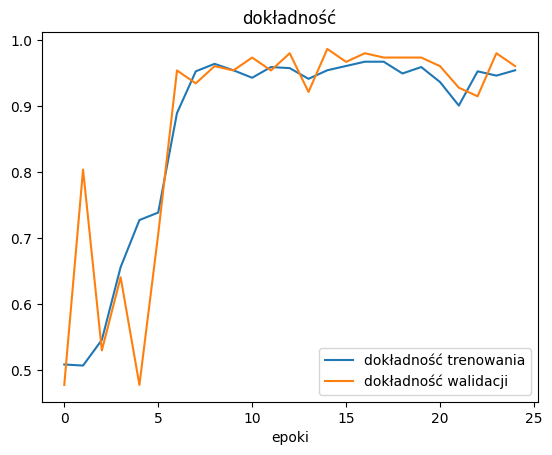

In [64]:
plot_curves(training_history_upgrade_6)

In [65]:
result_7 = model_cnn_upgrade_6.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result_7[1]*100:.2f}%\nLoss: {result_7[0]:.4f}")

Accuracy on Evaluation: 82.81%
Loss: 0.4392


In [66]:
y_true_7 = test_data.labels
y_pred_7 = model_cnn_upgrade_6.predict(test_data, verbose=0)
y_pred_7[y_pred_7 <= 0.5] = 0
y_pred_7[y_pred_7 > 0.5] = 1

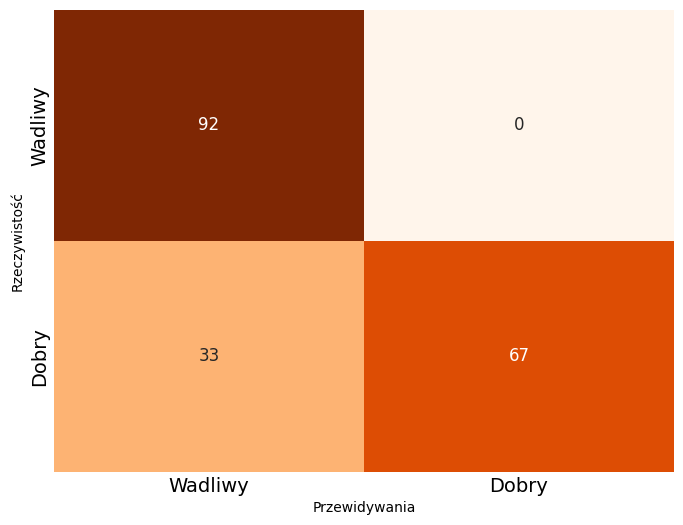

In [67]:
fig, ax = plt.subplots(figsize=(8,6))
ax=sns.heatmap(confusion_matrix(y_true_7,y_pred_7), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Oranges')
ax.set_xticklabels(['Wadliwy', 'Dobry'])
ax.set_yticklabels(['Wadliwy', 'Dobry'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.xlabel('Przewidywania')
plt.ylabel('Rzeczywistość')
plt.show()

In [68]:
print(classification_report(y_true_7, y_pred_7, digits=4))

              precision    recall  f1-score   support

           0     0.7360    1.0000    0.8479        92
           1     1.0000    0.6700    0.8024       100

    accuracy                         0.8281       192
   macro avg     0.8680    0.8350    0.8252       192
weighted avg     0.8735    0.8281    0.8242       192



In [3]:
model10_precision, model10_recall, model10_f1, accuracy_1, loss_1, fail_1 = 0.9896, 0.9896, 0.9896, 0.9896, 0.2312, 2
model15_precision, model15_recall, model15_f1, accuracy_2, loss_2, fail_2 = 0.9896, 0.9896, 0.9896, 0.9896, 0.1568, 2
model20_precision, model20_recall, model20_f1, accuracy_3, loss_3, fail_3 = 0.9950, 0.9946, 0.9948, 0.9948, 0.0529, 1
model25_precision, model25_recall, model25_f1, accuracy_4, loss_4, fail_4 = 0.8680, 0.8350, 0.8252, 0.8281, 0.4392, 33

metrics_df = pd.DataFrame([[model10_precision, model10_recall, model10_f1, accuracy_1, loss_1, fail_1],
                           [model15_precision, model15_recall, model15_f1, accuracy_2, loss_2, fail_2],
                           [model20_precision, model20_recall, model20_f1, accuracy_3, loss_3, fail_3],
                          [model25_precision, model25_recall, model25_f1, accuracy_4, loss_4, fail_4]],
                          index=['10 epok', '15 epok', '20 epok', '25 epok'])

metrics_df.columns = ['Precyzja', 'Czułość', 'F1-Score', 'Dokładność', 'Strata', 'Ilość błędnych klasyfikacji']

metrics_df 

,Precyzja,Czułość,F1-Score,Dokładność,Strata,Ilość błędnych klasyfikacji
10 epok,0.9896,0.9896,0.9896,0.9896,0.2312,2
15 epok,0.9896,0.9896,0.9896,0.9896,0.1568,2
20 epok,0.9950,0.9946,0.9948,0.9948,0.0529,1
25 epok,0.8680,0.8350,0.8252,0.8281,0.4392,33
